In [1]:
import quik_ai as qa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from importlib.metadata import version 
print('Quik-AI Version: %s' % version('quik_ai'))

Quik-AI Version: 1.0.0


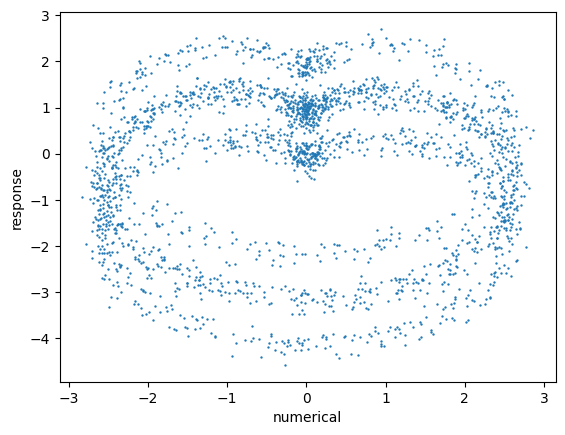

In [2]:
# build modified cardiac data: https://www.tensorflow.org/probability/api_docs/python/tfp/layers/MixtureNormal
n = 2400
time = np.random.uniform(low=-np.pi, high=np.pi, size=n)
radius = 2 * (1 - np.cos(time))

# build model predictors
hour = np.random.uniform(low=0, high=24, size=n)
x = radius * np.sin(time) + np.random.normal(loc=0., scale=0.1, size=n)
noise = np.random.normal(loc=0., scale=10, size=n)
categorical = np.random.choice(['A','B','C'], size=n, p=[0.2, 0.5, 0.3])

# build response
offset = (categorical == 'A').astype(float) - (categorical == 'C').astype(float)
y = radius * np.cos(time) + np.random.normal(loc=0., scale=0.1, size=n) + np.cos(hour / 24.0) + offset

# store in a dataframe
data = pd.DataFrame({
    'numerical' : x,
    'categorical' : categorical,
    'periodic' : hour,
    'noise' : noise,
    'response' : y,
})

# the joint distribution conditional on only x is a mess!
plt.scatter(data.numerical, data.response, s=0.5);
plt.xlabel('numerical');
plt.ylabel('response');

In [3]:
# split the data
training_data, validation_data, test_data = qa.train_val_test_split(data)

# create the driver, this will generate the tensorflow dataset and feed data
# also set the Noam optimizer
driver = qa.Driver(training_data, validation_data, test_data, qa.optimizers.Noam())

# what does our response look like?
head = qa.heads.GaussianMixture()

# all the predictors for the model
predictors = [
    qa.predictors.NumericalPredictor('numerical'),
    qa.predictors.CategoricalPredictor('categorical'),
    qa.predictors.PeriodicPredictor('periodic', 24.0),
    qa.predictors.NumericalPredictor('noise', drop=qa.tuning.HyperBoolean()),
]

# what is our model architecture? This will store
# our model, driver, and any other information we use in training
# testing, saving, and loading needed for this problem
model = qa.models.ResNet('response', head, predictors, driver)

# train the model, we can provide a hyperparameter tuner and other
# training parameters, by default we will use a custom BOHB tuner
model.train(qa.tuners.TunerContainer(qa.tuners.BOHB, max_epochs=1), full_rounds=1)

Trial 1 Complete [00h 00m 05s]
val_log_prob: 2.652933120727539

Best val_log_prob So Far: 2.652933120727539
Total elapsed time: 00h 00m 05s
INFO:tensorflow:Oracle triggered exit
Round 1 best score: 0.9863


In [4]:
# evaluate the model on test data
model.evaluate()

4/4 [==============================] - 1s 403ms/step - loss: 0.9925 - log_prob: 0.9925


{'loss': 0.9925137162208557, 'log_prob': 0.9925137162208557}

In [5]:
# save the model to disk and reload the model
# then test on the test data once again
model.save()
model = qa.HyperModel.load()

# evaluate again, this should be the same score as before
model.evaluate()

INFO:tensorflow:Assets written to: ./model\tf_model\assets


INFO:tensorflow:Assets written to: ./model\tf_model\assets


4/4 [==============================] - 1s 29ms/step - loss: 0.9925 - log_prob: 0.9925


{'loss': 0.9925137162208557, 'log_prob': 0.9925137162208557}

In [6]:
model.predict_distribution(test_data, np.arange(5))

<tf.Tensor: shape=(240, 5), dtype=float32, numpy=
array([[1.00995116e-01, 7.30371416e-01, 7.86431832e-04, 3.43364803e-08,
        6.77392586e-10],
       [1.43216059e-01, 4.86972630e-01, 1.31303808e-02, 9.63510480e-04,
        4.37251074e-05],
       [3.35646987e-01, 3.67067218e-01, 2.07795594e-02, 6.60395672e-05,
        2.33083483e-06],
       ...,
       [1.68248313e-03, 8.25047910e-01, 3.99751880e-04, 4.85814817e-05,
        1.46509237e-05],
       [4.57953662e-02, 1.16021663e-01, 4.19581354e-01, 1.55243254e-03,
        1.89876428e-05],
       [9.12864208e-01, 3.44277360e-04, 1.33036803e-02, 9.70034450e-02,
        3.99455021e-05]], dtype=float32)>